### Telecom Churn Prediction


#### Imports & Setup


In [5]:
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [6]:
# Feature Engineering Function
def add_features(df, refrence_date="2025-08-27"):
    """
    Add engineered features for churn prediction.
    df : pandas.DataFrame, Input dataset containing telecom churn features.
    ref : str, default="2025-08-27"- Reference date used to calculate tenure and recency-based features.
    Returns: DataFrame with new features and unnecessary columns dropped.
    """
    # Convert reference date to pandas timestamp
    refrence_date = pd.Timestamp(refrence_date)

    # Work on a copy to avoid modifying the original dataframe
    df = df.copy()

    # Customer tenure in days since signup
    df["tenure_days"] = (refrence_date - df["signup_date"]).dt.days

    # Days since last activity (recency feature)
    df["days_since_last_activity"] = (refrence_date - df["last_activity_ts"]).dt.days

    # New customer indicator (tenure < 90 days)
    df["is_new_customer"] = (df["tenure_days"] < 90).astype(int)

    # Support tickets per dropped call (add +1 to denominator to avoid division by zero)
    df["tickets_per_dropped"] = df["num_support_tickets_last_3m"] / (df["num_dropped_calls_last_30d"] + 1)

    # Drop identifiers and raw timestamps (avoid data leakage and high-cardinality features)
    df = df.drop(columns=["customer_id", "signup_date", "last_activity_ts"])

    return df


#### Load and Inspect Data

In [7]:
# Load data 
df = pd.read_csv("telecom_churn_full.csv", parse_dates=["signup_date","last_activity_ts"])


In [8]:
# 1) Basic info
print("Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

Shape: (2000, 23)

Data Types:
customer_id                             int64
signup_date                    datetime64[ns]
last_activity_ts               datetime64[ns]
plan_type                              object
monthly_data_gb                       float64
avg_call_minutes                      float64
num_support_tickets_last_3m             int64
num_dropped_calls_last_30d              int64
payment_method                         object
auto_pay                                int64
last_bill_amount                      float64
is_promo                                int64
city                                   object
region                                 object
device_type                            object
contract_type                          object
data_overage_gb_last_3m               float64
intl_call_minutes_last_3m             float64
complaints_last_3m                      int64
net_promoter_score                    float64
age                                     int64
gen

In [9]:
# Check missing values
print("\nMissing Values per Column:")
print(df.isna().sum())



Missing Values per Column:
customer_id                      0
signup_date                      0
last_activity_ts                 0
plan_type                        0
monthly_data_gb                126
avg_call_minutes               139
num_support_tickets_last_3m      0
num_dropped_calls_last_30d       0
payment_method                  74
auto_pay                         0
last_bill_amount                 0
is_promo                         0
city                             0
region                           0
device_type                      0
contract_type                    0
data_overage_gb_last_3m          0
intl_call_minutes_last_3m        0
complaints_last_3m               0
net_promoter_score             164
age                              0
gender                           0
churn                            0
dtype: int64


In [10]:
# Check duplicates
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [11]:
#  Target balance (churn distribution)
print("\nChurn distribution:")
print(df['churn'].value_counts(normalize=True))


Churn distribution:
churn
0    0.7615
1    0.2385
Name: proportion, dtype: float64


In [12]:
#  Quick numeric summary
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
         customer_id                    signup_date  \
count    2000.000000                           2000   
mean   100999.500000  2023-10-05 02:56:23.100541184   
min    100000.000000  2022-01-01 15:53:54.496285952   
25%    100499.750000  2022-11-08 16:16:34.250086400   
50%    100999.500000  2023-09-26 09:45:13.389315328   
75%    101499.250000  2024-08-30 01:39:12.560637952   
max    101999.000000  2025-06-30 06:16:57.626050560   
std       577.494589                            NaN   

                    last_activity_ts  monthly_data_gb  avg_call_minutes  \
count                           2000      1874.000000       1861.000000   
mean   2025-06-15 09:02:09.635416576        18.133725        256.748148   
min    2025-05-01 01:25:05.543649792         1.226404         10.000000   
25%    2025-05-23 14:46:52.407721472        10.990746        194.001785   
50%    2025-06-15 13:03:39.916902400        15.938957        249.270364   
75%    2025-07-08 14:24:20.425875

Matplotlib is building the font cache; this may take a moment.


churn
0    1523
1     477
Name: count, dtype: int64


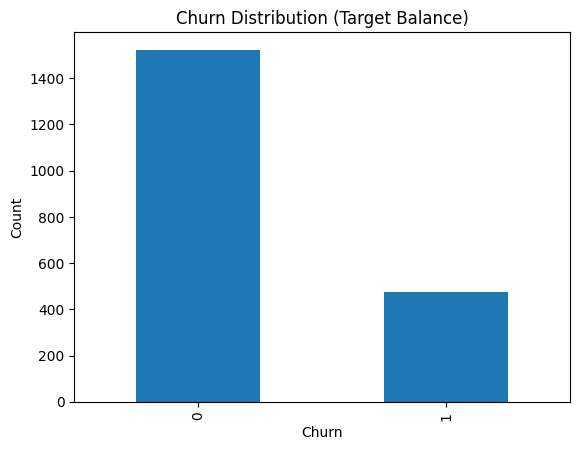

In [13]:
#  visualize imbalance
import matplotlib.pyplot as plt
print(df['churn'].value_counts())
df['churn'].value_counts().plot(kind="bar")
plt.title("Churn Distribution (Target Balance)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

#### Feature Engineering

In [14]:
df_new = add_features(df)
display(df_new.head(), df_new.shape)

,plan_type,monthly_data_gb,avg_call_minutes,num_support_tickets_last_3m,num_dropped_calls_last_30d,payment_method,auto_pay,last_bill_amount,is_promo,city,...,intl_call_minutes_last_3m,complaints_last_3m,net_promoter_score,age,gender,churn,tenure_days,days_since_last_activity,is_new_customer,tickets_per_dropped
0,Standard,8.282826,291.162602,0,2,credit_card,0,95.514717,1,Cairo,...,50.494030,0,8.0,24,M,0,345,40,0,0.000000
1,Basic,12.028792,NaN,0,0,wallet,0,97.148673,0,Ismailia,...,27.638448,1,4.0,66,F,0,773,76,0,0.000000
2,Premium,11.019622,259.389260,1,1,cash,1,109.951897,0,Giza,...,0.000000,0,-9.0,51,F,0,237,30,0,0.500000
3,Basic,13.410801,91.825116,1,2,wallet,1,88.091393,0,Cairo,...,0.153579,1,9.0,39,F,1,443,58,0,0.333333
4,Standard,20.296799,352.166485,2,1,wallet,1,144.459742,0,Giza,...,53.295349,0,2.0,66,M,1,1213,107,0,1.000000


(2000, 24)

#### Train Test Split

In [15]:
X = df_new.drop(columns=["churn"])
y = df_new["churn"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [17]:
# Columns by dtype
numeric_features = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["number"]).columns.tolist()

#### Data Preprocessing And Cleaning
- Handling Missing Values
- Encoding Categorical Columns


In [18]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [19]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [20]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

#### Models Preparation

In [21]:
models = {
    "Logreg": LogisticRegression(max_iter=500, class_weight="balanced"),
    "rf": RandomForestClassifier(n_estimators=350, random_state=42, class_weight="balanced_subsample"),
    "knn": KNeighborsClassifier(n_neighbors=7,weights="distance"),
    "svm": SVC(probability=True, kernel="rbf", class_weight="balanced", C=1.0, gamma="scale"),
    "ann": MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", solver="adam", alpha=1e-4, learning_rate="adaptive",max_iter=400, early_stopping=True, random_state=42)
}

#### Train & Test 
- Cross Validation on train 
- Evaluate on held-out test 


Logreg 5-fold CV Balanced Accuracy: 0.691 +/- 0.024
Logreg Test Accuracy: 0.690
              precision    recall  f1-score   support

           0       0.86      0.70      0.78       305
           1       0.40      0.64      0.50        95

    accuracy                           0.69       400
   macro avg       0.63      0.67      0.64       400
weighted avg       0.75      0.69      0.71       400

rf 5-fold CV Balanced Accuracy: 0.518 +/- 0.008
rf Test Accuracy: 0.770
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       305
           1       0.62      0.08      0.15        95

    accuracy                           0.77       400
   macro avg       0.70      0.53      0.51       400
weighted avg       0.74      0.77      0.70       400

knn 5-fold CV Balanced Accuracy: 0.537 +/- 0.009
knn Test Accuracy: 0.743
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       305
           

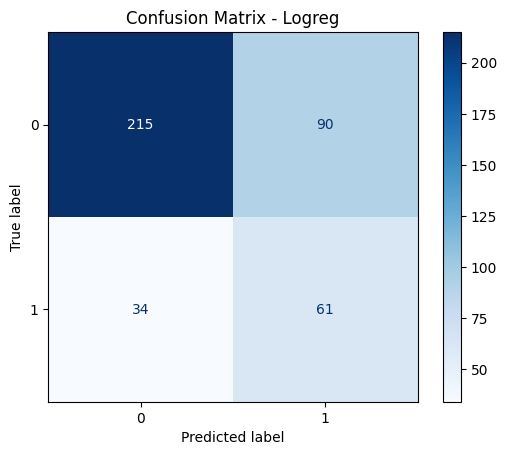

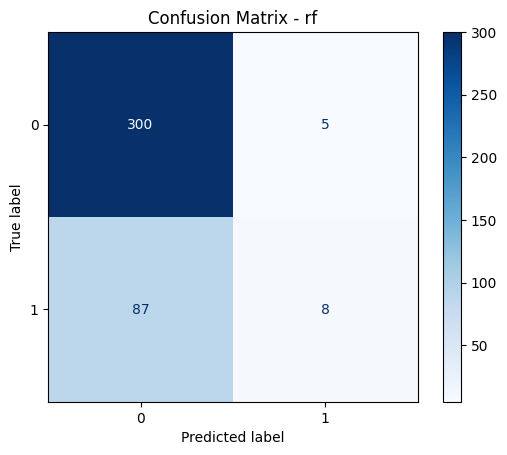

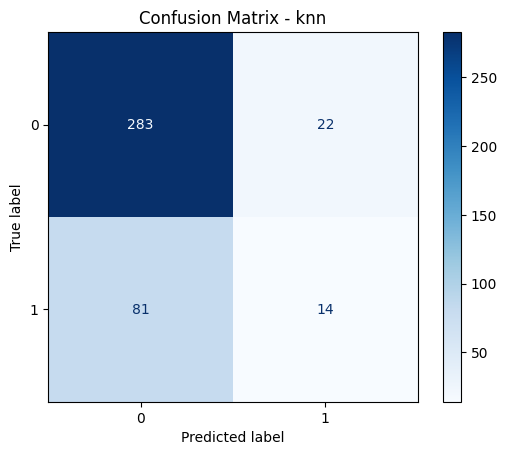

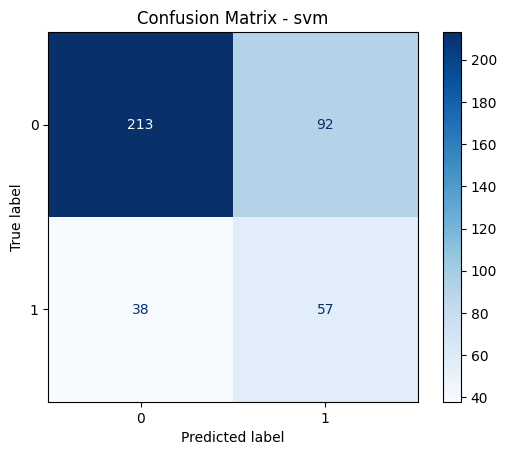

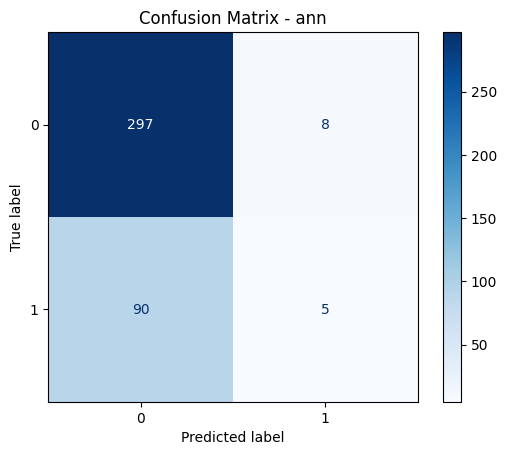

In [22]:
pipelines = {}
for name, model in models.items():
    clf = Pipeline(steps=[("preprocess", preprocess),
                         ("model", model)])
    # 5-fold CV Balanced Accuracy
    bal_acc = cross_val_score(clf, X_train, y_train, cv=5, scoring="balanced_accuracy")
    print(f"{name} 5-fold CV Balanced Accuracy: {bal_acc.mean():.3f} +/- {bal_acc.std():.3f}")
    # Fit full train
    clf.fit(X_train, y_train)
    pipelines[name] = clf
    # Held-out test
    y_pred = clf.predict(X_test)
    print(f"{name} Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")  # optional

In [23]:
import joblib

In [24]:
joblib.dump(pipelines, "all_churn_pipelines.pkl")
X_test.to_csv("X_test_churn.csv", index=False)
y_test.to_csv("y_test_churn.csv", index=False)